# Feature Engineering for Fraud Detection

**Business Objective**: Create fraud-relevant features that capture behavioral patterns, temporal signals, and geolocation risk indicators.

**Feature Categories**:
1. **Geolocation Features**: IP-to-Country mapping for risk assessment
2. **Time-Based Features**: Hour, day, time since signup, temporal patterns
3. **Velocity Features**: Transaction frequency in time windows
4. **Frequency Features**: User and device transaction counts
5. **Behavioral Features**: Device sharing, browser patterns

**Business Value**: These features directly capture fraud indicators observed in real-world fraud patterns.


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import pickle

# Add src to path - works in both Jupyter and regular Python
# Method 1: Try relative path (works when running from notebooks directory)
src_path_rel = Path('../src').resolve()
if src_path_rel.exists() and str(src_path_rel) not in sys.path:
    sys.path.insert(0, str(src_path_rel))

# Method 2: Try absolute path from current working directory
src_path_abs = Path.cwd().parent / 'src' if Path.cwd().name == 'notebooks' else Path.cwd() / 'src'
if src_path_abs.exists() and str(src_path_abs) not in sys.path:
    sys.path.insert(0, str(src_path_abs))

# Import custom modules
from data_loader import load_fraud_data, load_ip_country_mapping
from preprocessing import (
    clean_fraud_data, 
    add_geolocation_features, 
    engineer_time_features,
    engineer_velocity_features,
    engineer_frequency_features,
    prepare_features_for_modeling,
    handle_class_imbalance
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")


Libraries imported successfully


## 1. Load and Clean Data


In [4]:
# Load fraud data
# Resolve path correctly regardless of working directory
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_path = project_root / 'data' / 'raw' / 'Fraud_Data.csv'

try:
    # Try absolute path first
    if data_path.exists():
        df = load_fraud_data(str(data_path))
        print(f"✓ Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
    else:
        # Try relative path as fallback
        rel_path = Path("../data/raw/Fraud_Data.csv").resolve()
        if rel_path.exists():
            df = load_fraud_data(str(rel_path))
            print(f"✓ Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
        else:
            raise FileNotFoundError(f"Fraud data file not found at {data_path} or {rel_path}")
    
    # Clean data
    df = clean_fraud_data(df)
    print(f"✓ Cleaned: {df.shape[0]:,} rows after cleaning")
    
except FileNotFoundError as e:
    print(f"⚠ Data file not found: {e}")
    print(f"   Current working directory: {Path.cwd()}")
    print(f"   Looking for file at: {data_path}")
    print(f"   File exists: {data_path.exists()}")
    df = None
except Exception as e:
    print(f"⚠ Error loading data: {e}")
    import traceback
    traceback.print_exc()
    df = None


✓ Loaded: 151,112 rows, 11 columns
✓ Cleaned: 151,112 rows after cleaning


## 2. Geolocation Integration (IP to Country Mapping)

**Business Rationale**: 
- High-risk countries are strong fraud indicators
- Geolocation mismatches (user location vs transaction location) indicate account takeover
- Regional fraud patterns help identify coordinated attacks


✓ Loaded IP mapping: 138,846 IP ranges

Sample IP ranges:


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China



INTEGRATING GEOLOCATION DATA

✓ Geolocation features added
  Unique countries mapped: 182
  Unknown countries: 21,966 (14.54%)

Top 10 Countries by Fraud Rate:


,country,total_transactions,fraud_count,fraud_rate
166,Turkmenistan,1,1,1.000000
115,Namibia,23,10,0.434783
154,Sri Lanka,31,13,0.419355
98,Luxembourg,72,28,0.388889
178,Virgin Islands (U.S.),3,1,0.333333
51,Ecuador,106,28,0.264151
164,Tunisia,118,31,0.262712
131,Peru,119,31,0.260504
20,Bolivia,53,13,0.245283
89,Kuwait,90,21,0.233333


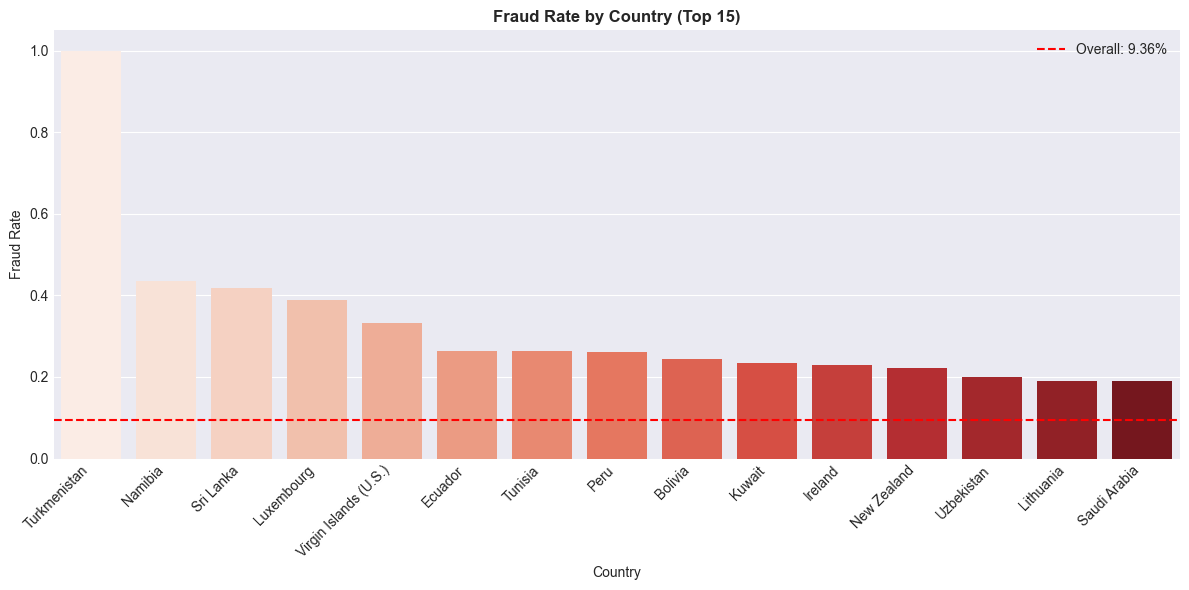


✓ High-risk country flag created: 23 countries


In [5]:
# Load IP to Country mapping
# Resolve path correctly regardless of working directory
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
ip_mapping_path = project_root / 'data' / 'raw' / 'IpAddress_to_Country.csv'

try:
    # Try absolute path first
    if ip_mapping_path.exists():
        ip_country_df = load_ip_country_mapping(str(ip_mapping_path))
        print(f"✓ Loaded IP mapping: {ip_country_df.shape[0]:,} IP ranges")
    else:
        # Try relative path as fallback
        rel_path = Path("../data/raw/IpAddress_to_Country.csv").resolve()
        if rel_path.exists():
            ip_country_df = load_ip_country_mapping(str(rel_path))
            print(f"✓ Loaded IP mapping: {ip_country_df.shape[0]:,} IP ranges")
        else:
            raise FileNotFoundError(f"IP country mapping file not found at {ip_mapping_path} or {rel_path}")
    print(f"\nSample IP ranges:")
    display(ip_country_df.head())
    
    # Add geolocation features
    # Check if df exists and has required column
    try:
        df_exists = df is not None and 'ip_address' in df.columns
    except NameError:
        print("⚠ Variable 'df' is not defined. Please run Cell 3 (Load and Clean Data) first.")
        df_exists = False
    
    if df_exists:
        print("\n" + "=" * 60)
        print("INTEGRATING GEOLOCATION DATA")
        print("=" * 60)
        
        initial_countries = df['ip_address'].nunique() if 'ip_address' in df.columns else 0
        
        df = add_geolocation_features(df, ip_country_df)
        
        print(f"\n✓ Geolocation features added")
        print(f"  Unique countries mapped: {df['country'].nunique()}")
        print(f"  Unknown countries: {(df['country'] == 'Unknown').sum():,} ({(df['country'] == 'Unknown').sum()/len(df)*100:.2f}%)")
        
        # Analyze fraud by country
        if 'class' in df.columns:
            fraud_by_country = df.groupby('country').agg({
                'class': ['count', 'sum', 'mean']
            }).reset_index()
            fraud_by_country.columns = ['country', 'total_transactions', 'fraud_count', 'fraud_rate']
            fraud_by_country = fraud_by_country.sort_values('fraud_rate', ascending=False)
            
            print("\nTop 10 Countries by Fraud Rate:")
            display(fraud_by_country.head(10))
            
            # Visualize fraud rates by country
            top_countries = fraud_by_country.head(15)
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_countries, x='country', y='fraud_rate', palette='Reds')
            plt.title('Fraud Rate by Country (Top 15)', fontweight='bold')
            plt.xlabel('Country')
            plt.ylabel('Fraud Rate')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=df['class'].mean(), color='r', linestyle='--', 
                       label=f'Overall: {df["class"].mean():.2%}')
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Create high-risk country flag
            high_risk_threshold = df['class'].mean() * 1.5  # 50% above average
            high_risk_countries = fraud_by_country[fraud_by_country['fraud_rate'] > high_risk_threshold]['country'].tolist()
            df['is_high_risk_country'] = df['country'].isin(high_risk_countries).astype(int)
            print(f"\n✓ High-risk country flag created: {len(high_risk_countries)} countries")
            
except FileNotFoundError as e:
    print(f"⚠ IP mapping file not found: {e}")
    print(f"   Current working directory: {Path.cwd()}")
    if 'ip_mapping_path' in locals():
        print(f"   Looking for file at: {ip_mapping_path}")
        print(f"   File exists: {ip_mapping_path.exists()}")
    try:
        if df is not None:
            df['country'] = 'Unknown'
            df['is_high_risk_country'] = 0
    except NameError:
        print("⚠ Variable 'df' is not defined. Please run Cell 3 (Load and Clean Data) first.")
except Exception as e:
    print(f"⚠ Error loading IP mapping: {e}")
    import traceback
    traceback.print_exc()
    try:
        if df is not None:
            df['country'] = 'Unknown'
            df['is_high_risk_country'] = 0
    except NameError:
        print("⚠ Variable 'df' is not defined. Please run Cell 3 (Load and Clean Data) first.")


## 3. Time-Based Feature Engineering

**Business Rationale**:
- Fraud often occurs at unusual hours (late night, early morning)
- New accounts (recent signups) are higher risk
- Weekend patterns differ from weekday patterns
- Time since signup indicates account maturity


ENGINEERING TIME-BASED FEATURES

✓ Created 7 time-based features:


  - hour_of_day
  - day_of_week
  - is_weekend
  - is_night
  - time_since_signup
  - time_since_signup_days
  - is_new_account

Fraud Rate by Time Features:


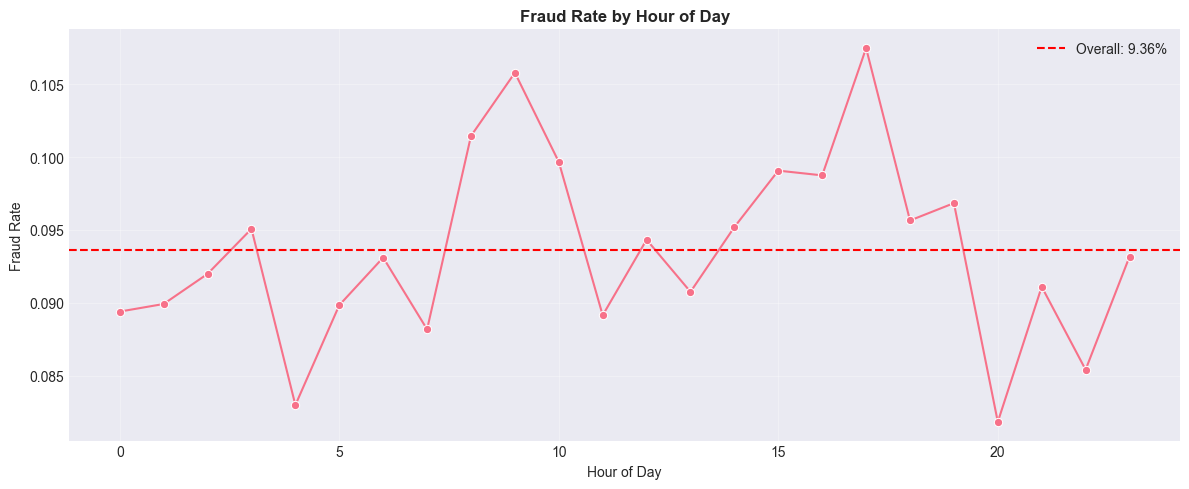


Fraud Rate by Account Age:


,is_new_account,count,fraud_count,fraud_rate
0,0,142354,6503,0.045682
1,1,8758,7648,0.873259


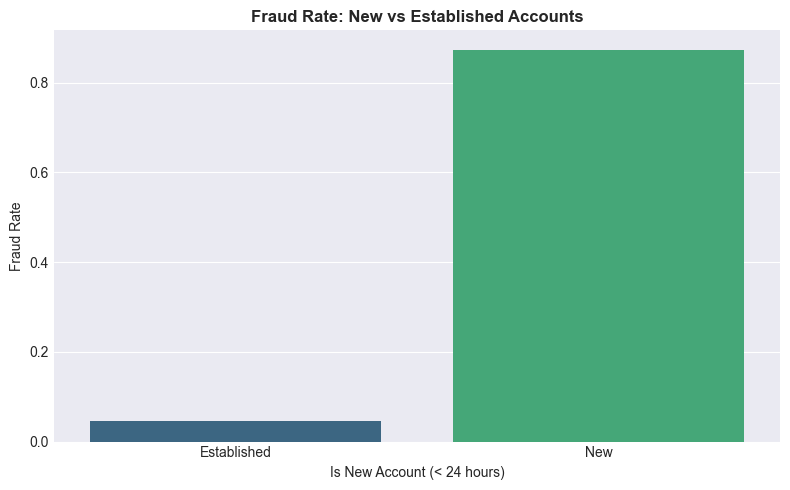


Fraud Rate - Weekday: 9.10%, Weekend: 10.01%
Fraud Rate - Day: 9.56%, Night: 8.98%


In [6]:
# Engineer time-based features
try:
    if df is not None and 'purchase_time' in df.columns:
        print("=" * 60)
        print("ENGINEERING TIME-BASED FEATURES")
        print("=" * 60)
        
        df = engineer_time_features(df)
        
        # Show new features
        time_features = ['hour_of_day', 'day_of_week', 'is_weekend', 'is_night', 
                         'time_since_signup', 'time_since_signup_days', 'is_new_account']
        new_time_features = [f for f in time_features if f in df.columns]
        
        print(f"\n✓ Created {len(new_time_features)} time-based features:")
        for feat in new_time_features:
            print(f"  - {feat}")
        
        # Analyze fraud patterns by time features
        if 'class' in df.columns:
            print("\nFraud Rate by Time Features:")
            
            # Hour of day
            if 'hour_of_day' in df.columns:
                fraud_by_hour = df.groupby('hour_of_day')['class'].mean().reset_index()
                fraud_by_hour.columns = ['hour', 'fraud_rate']
                
                plt.figure(figsize=(12, 5))
                sns.lineplot(data=fraud_by_hour, x='hour', y='fraud_rate', marker='o')
                plt.title('Fraud Rate by Hour of Day', fontweight='bold')
                plt.xlabel('Hour of Day')
                plt.ylabel('Fraud Rate')
                plt.axhline(y=df['class'].mean(), color='r', linestyle='--', 
                           label=f'Overall: {df["class"].mean():.2%}')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            
            # New account analysis
            if 'is_new_account' in df.columns:
                new_account_fraud = df.groupby('is_new_account')['class'].agg(['count', 'sum', 'mean']).reset_index()
                new_account_fraud.columns = ['is_new_account', 'count', 'fraud_count', 'fraud_rate']
                print("\nFraud Rate by Account Age:")
                display(new_account_fraud)
                
                # Visualize
                plt.figure(figsize=(8, 5))
                sns.barplot(data=new_account_fraud, x='is_new_account', y='fraud_rate', palette='viridis')
                plt.title('Fraud Rate: New vs Established Accounts', fontweight='bold')
                plt.xlabel('Is New Account (< 24 hours)')
                plt.ylabel('Fraud Rate')
                plt.xticks([0, 1], ['Established', 'New'])
                plt.tight_layout()
                plt.show()
            
            # Weekend analysis
            if 'is_weekend' in df.columns:
                weekend_fraud = df.groupby('is_weekend')['class'].mean()
                print(f"\nFraud Rate - Weekday: {weekend_fraud[0]:.2%}, Weekend: {weekend_fraud[1]:.2%}")
            
            # Night transactions
            if 'is_night' in df.columns:
                night_fraud = df.groupby('is_night')['class'].mean()
                print(f"Fraud Rate - Day: {night_fraud[0]:.2%}, Night: {night_fraud[1]:.2%}")
    else:
        print("⚠ Data not loaded or 'purchase_time' column missing. Please run the data loading cells first.")
except NameError:
    print("⚠ Variable 'df' is not defined. Please run the data loading cells (Cells 2 and 3) first.")
except Exception as e:
    print(f"⚠ Error in time-based feature engineering: {e}")
    import traceback
    traceback.print_exc()


## 4. Velocity Feature Engineering

**Business Rationale**:
- High transaction frequency in short time windows = fraud indicator
- Rapid successive transactions from same user/device = suspicious
- Velocity features capture behavioral anomalies


In [ ]:
# Engineer velocity features
if df is not None and 'purchase_time' in df.columns and 'user_id' in df.columns:
    print("=" * 60)
    print("ENGINEERING VELOCITY FEATURES")
    print("=" * 60)
    print("\n⚠ This may take a few minutes for large datasets...")
    
    df = engineer_velocity_features(df, time_window_hours=24)
    
    velocity_features = ['transactions_last_24h', 'transactions_last_1h', 
                         'high_velocity_24h', 'high_velocity_1h']
    new_velocity_features = [f for f in velocity_features if f in df.columns]
    
    print(f"\n✓ Created {len(new_velocity_features)} velocity features:")
    for feat in new_velocity_features:
        print(f"  - {feat}")
    
    # Analyze fraud by velocity
    if 'class' in df.columns:
        print("\nFraud Rate by Velocity Features:")
        
        if 'high_velocity_24h' in df.columns:
            velocity_fraud = df.groupby('high_velocity_24h')['class'].agg(['count', 'sum', 'mean']).reset_index()
            velocity_fraud.columns = ['high_velocity_24h', 'count', 'fraud_count', 'fraud_rate']
            print("\n24-Hour Velocity:")
            display(velocity_fraud)
            
            # Visualize
            plt.figure(figsize=(10, 5))
            sns.barplot(data=velocity_fraud, x='high_velocity_24h', y='fraud_rate', palette='Reds')
            plt.title('Fraud Rate by 24-Hour Velocity', fontweight='bold')
            plt.xlabel('High Velocity (≥5 transactions in 24h)')
            plt.ylabel('Fraud Rate')
            plt.xticks([0, 1], ['Normal', 'High Velocity'])
            plt.axhline(y=df['class'].mean(), color='r', linestyle='--', 
                       label=f'Overall: {df["class"].mean():.2%}')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        # Distribution of transaction counts
        if 'transactions_last_24h' in df.columns:
            plt.figure(figsize=(12, 5))
            ax1 = plt.subplot(1, 2, 1)
            df['transactions_last_24h'].hist(bins=30, ax=ax1, edgecolor='black')
            ax1.set_title('Distribution: Transactions in Last 24h', fontweight='bold')
            ax1.set_xlabel('Transaction Count')
            ax1.set_ylabel('Frequency')
            
            ax2 = plt.subplot(1, 2, 2)
            fraud_by_velocity = df.groupby('transactions_last_24h')['class'].mean().reset_index()
            fraud_by_velocity.columns = ['transactions_24h', 'fraud_rate']
            sns.lineplot(data=fraud_by_velocity, x='transactions_24h', y='fraud_rate', ax=ax2)
            ax2.set_title('Fraud Rate by Transaction Count (24h)', fontweight='bold')
            ax2.set_xlabel('Transactions in Last 24h')
            ax2.set_ylabel('Fraud Rate')
            ax2.set_xlim(0, min(20, fraud_by_velocity['transactions_24h'].max()))
            plt.tight_layout()
            plt.show()


ENGINEERING VELOCITY FEATURES

⚠ This may take a few minutes for large datasets...


## 5. Frequency Feature Engineering

**Business Rationale**:
- Users with many transactions may be power users or fraudsters
- Shared devices indicate account sharing or compromised accounts
- Browser patterns reveal device fingerprinting opportunities


In [ ]:
# Engineer frequency features
if df is not None:
    print("=" * 60)
    print("ENGINEERING FREQUENCY FEATURES")
    print("=" * 60)
    
    df = engineer_frequency_features(df)
    
    frequency_features = ['user_transaction_count', 'device_usage_count', 'is_shared_device', 
                         'browser_usage_count']
    new_frequency_features = [f for f in frequency_features if f in df.columns]
    
    print(f"\n✓ Created {len(new_frequency_features)} frequency features:")
    for feat in new_frequency_features:
        print(f"  - {feat}")
    
    # Analyze fraud by frequency
    if 'class' in df.columns:
        print("\nFraud Rate by Frequency Features:")
        
        if 'is_shared_device' in df.columns:
            device_fraud = df.groupby('is_shared_device')['class'].agg(['count', 'sum', 'mean']).reset_index()
            device_fraud.columns = ['is_shared_device', 'count', 'fraud_count', 'fraud_rate']
            print("\nShared Device Analysis:")
            display(device_fraud)
            
            # Visualize
            plt.figure(figsize=(8, 5))
            sns.barplot(data=device_fraud, x='is_shared_device', y='fraud_rate', palette='viridis')
            plt.title('Fraud Rate: Shared vs Personal Devices', fontweight='bold')
            plt.xlabel('Is Shared Device (>10 users)')
            plt.ylabel('Fraud Rate')
            plt.xticks([0, 1], ['Personal', 'Shared'])
            plt.axhline(y=df['class'].mean(), color='r', linestyle='--', 
                       label=f'Overall: {df["class"].mean():.2%}')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        # User transaction count analysis
        if 'user_transaction_count' in df.columns:
            # Create bins for analysis
            df['user_txn_bin'] = pd.cut(df['user_transaction_count'], 
                                        bins=[0, 1, 5, 10, 50, float('inf')],
                                        labels=['1', '2-5', '6-10', '11-50', '50+'])
            
            txn_bin_fraud = df.groupby('user_txn_bin')['class'].agg(['count', 'sum', 'mean']).reset_index()
            txn_bin_fraud.columns = ['txn_bin', 'count', 'fraud_count', 'fraud_rate']
            print("\nFraud Rate by User Transaction Count:")
            display(txn_bin_fraud)


## 6. Feature Summary and Validation


In [ ]:
# Summary of all engineered features
if df is not None:
    print("=" * 60)
    print("FEATURE ENGINEERING SUMMARY")
    print("=" * 60)
    
    print(f"\nTotal Features: {df.shape[1]}")
    print(f"Total Rows: {df.shape[0]:,}")
    
    # Categorize features
    original_features = ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 
                        'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']
    
    geolocation_features = [col for col in df.columns if 'country' in col.lower() or 'risk' in col.lower()]
    time_features = [col for col in df.columns if any(x in col.lower() for x in ['hour', 'day', 'week', 'time_since', 'new_account', 'night', 'weekend'])]
    velocity_features = [col for col in df.columns if 'velocity' in col.lower() or 'transactions_last' in col.lower()]
    frequency_features = [col for col in df.columns if 'count' in col.lower() or 'shared' in col.lower()]
    
    print(f"\nFeature Categories:")
    print(f"  Original: {len([f for f in original_features if f in df.columns])}")
    print(f"  Geolocation: {len(geolocation_features)}")
    print(f"  Time-based: {len(time_features)}")
    print(f"  Velocity: {len(velocity_features)}")
    print(f"  Frequency: {len(frequency_features)}")
    
    print(f"\nEngineered Features List:")
    all_engineered = geolocation_features + time_features + velocity_features + frequency_features
    for feat in sorted(set(all_engineered)):
        print(f"  - {feat}")
    
    # Save feature-engineered dataset
    output_path = Path("../data/processed/fraud_data_featured.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"\n✓ Feature-engineered data saved to: {output_path}")
    
    # Feature importance preview (correlation with target)
    if 'class' in df.columns:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if 'class' in numeric_cols:
            numeric_cols.remove('class')
        
        correlations = df[numeric_cols + ['class']].corr()['class'].drop('class').abs().sort_values(ascending=False)
        
        print("\n" + "=" * 60)
        print("TOP 15 FEATURES BY CORRELATION WITH FRAUD")
        print("=" * 60)
        display(correlations.head(15).to_frame('Correlation'))
        
        # Visualize top features
        plt.figure(figsize=(10, 8))
        top_features = correlations.head(15)
        sns.barplot(x=top_features.values, y=top_features.index, palette='Reds')
        plt.title('Top 15 Features by Fraud Correlation', fontweight='bold')
        plt.xlabel('Absolute Correlation with Fraud')
        plt.tight_layout()
        plt.show()


## 7. Prepare Data for Modeling

**Next Steps**:
- Train-test split (CRITICAL: before any resampling)
- Handle class imbalance on training set only
- Scale numerical features
- Encode categorical variables


In [ ]:
# Prepare features for modeling
if df is not None and 'class' in df.columns:
    from sklearn.model_selection import train_test_split
    
    print("=" * 60)
    print("PREPARING DATA FOR MODELING")
    print("=" * 60)
    
    # Identify feature columns (exclude IDs and timestamps)
    exclude_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Separate features and target
    X = df[feature_cols].copy()
    y = df['class'].copy()
    
    print(f"\nFeatures: {X.shape[1]}")
    print(f"Samples: {X.shape[0]:,}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # CRITICAL: Train-test split BEFORE any resampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n✓ Train-Test Split (80-20):")
    print(f"  Training: {X_train.shape[0]:,} samples")
    print(f"  Testing:  {X_test.shape[0]:,} samples")
    print(f"\n  Training class distribution:")
    print(f"    Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean():.2%})")
    print(f"    Fraud:     {(y_train == 1).sum():,} ({(y_train == 1).mean():.2%})")
    
    # Prepare features (scaling, encoding)
    X_train_processed, y_train_processed, preprocessing_dict = prepare_features_for_modeling(
        pd.concat([X_train, y_train], axis=1),
        target_col='class',
        scaler_type='standard'
    )
    
    # Apply same transformations to test set
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    
    # For test set, we need to apply the same transformations
    # This is simplified - in production, use a Pipeline
    X_test_processed = X_test.copy()
    
    # Scale numerical features (using same scaler)
    numerical_cols = preprocessing_dict['numerical_cols']
    if len(numerical_cols) > 0:
        scaler = preprocessing_dict['scaler']
        X_test_processed[numerical_cols] = scaler.transform(X_test_processed[numerical_cols])
    
    # One-hot encode categorical (ensure same columns)
    categorical_cols = preprocessing_dict['categorical_cols']
    X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_cols, 
                                     prefix=categorical_cols, drop_first=True)
    
    # Align columns (add missing, remove extra)
    X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)
    
    print(f"\n✓ Features prepared:")
    print(f"  Training shape: {X_train_processed.shape}")
    print(f"  Testing shape:  {X_test_processed.shape}")
    
    # Save preprocessed data
    train_output = Path("../data/processed/train_features.csv")
    test_output = Path("../data/processed/test_features.csv")
    
    pd.concat([X_train_processed, y_train_processed], axis=1).to_csv(train_output, index=False)
    pd.concat([X_test_processed, y_test], axis=1).to_csv(test_output, index=False)
    
    print(f"\n✓ Preprocessed data saved:")
    print(f"  Training: {train_output}")
    print(f"  Testing:  {test_output}")
    
    # Save preprocessing artifacts
    artifacts_path = Path("../models/preprocessing_artifacts.pkl")
    artifacts_path.parent.mkdir(parents=True, exist_ok=True)
    with open(artifacts_path, 'wb') as f:
        pickle.dump(preprocessing_dict, f)
    print(f"  Artifacts: {artifacts_path}")


## 8. Handle Class Imbalance (Training Set Only)

**Business Justification**:
- SMOTE creates synthetic minority samples, preserving all majority samples
- Best when we have sufficient data and want to minimize information loss
- Applied ONLY to training set to prevent data leakage


In [ ]:
# Handle class imbalance on training set
if 'X_train_processed' in locals() and 'y_train_processed' in locals():
    print("=" * 60)
    print("HANDLING CLASS IMBALANCE")
    print("=" * 60)
    
    print("\nBEFORE Resampling:")
    print(f"  Non-Fraud: {(y_train_processed == 0).sum():,} ({(y_train_processed == 0).mean():.2%})")
    print(f"  Fraud:     {(y_train_processed == 1).sum():,} ({(y_train_processed == 1).mean():.2%})")
    print(f"  Ratio:     {(y_train_processed == 0).sum() / (y_train_processed == 1).sum():.1f}:1")
    
    # Apply SMOTE
    # sampling_strategy=0.5 means 1:2 ratio (fraud:non-fraud)
    X_train_resampled, y_train_resampled = handle_class_imbalance(
        X_train_processed, 
        y_train_processed,
        method='smote',
        sampling_strategy=0.5
    )
    
    print("\nAFTER SMOTE (sampling_strategy=0.5):")
    print(f"  Non-Fraud: {(y_train_resampled == 0).sum():,} ({(y_train_resampled == 0).mean():.2%})")
    print(f"  Fraud:     {(y_train_resampled == 1).sum():,} ({(y_train_resampled == 1).mean():.2%})")
    print(f"  Ratio:     {(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.1f}:1")
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    before_dist = pd.Series(y_train_processed).value_counts().sort_index()
    after_dist = pd.Series(y_train_resampled).value_counts().sort_index()
    
    axes[0].bar(['Non-Fraud', 'Fraud'], before_dist.values, color=['green', 'red'], alpha=0.7)
    axes[0].set_title('Before Resampling', fontweight='bold')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(before_dist.values):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
    
    axes[1].bar(['Non-Fraud', 'Fraud'], after_dist.values, color=['green', 'red'], alpha=0.7)
    axes[1].set_title('After SMOTE', fontweight='bold')
    axes[1].set_ylabel('Count')
    for i, v in enumerate(after_dist.values):
        axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Save resampled training data
    resampled_output = Path("../data/processed/train_features_resampled.csv")
    pd.concat([X_train_resampled, y_train_resampled], axis=1).to_csv(resampled_output, index=False)
    print(f"\n✓ Resampled training data saved: {resampled_output}")
    
    print("\n" + "=" * 60)
    print("READY FOR MODELING")
    print("=" * 60)
    print("✓ Features engineered and validated")
    print("✓ Data split into train/test (80/20)")
    print("✓ Class imbalance handled on training set")
    print("✓ Preprocessing pipeline saved for reproducibility")
    print("\nNext: Proceed to modeling.ipynb")
    print("=" * 60)
